In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from salishsea_tools import (tidetools, geo_tools, viz_tools, gsw_calls)
import numpy.ma as ma
import pandas as pd
import datetime
import pytz
import os
%matplotlib inline

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)

In [4]:
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')

In [5]:
HINDCAST_PATH= '/results/SalishSea/nowcast-green/'

In [6]:
f = pd.read_csv('/ocean/eolson/MEOPAR/obs/NANOOS_SJPEF/ticket2180-csv/Discrete.csv')
f.keys()

Index(['year', 'month', 'day', 'time', 'depth', 'station', 'chl', 'phaeo',
       'o2', 'po4', 'sio4', 'no3', 'no2', 'nh4'],
      dtype='object')

In [7]:
f.shape

(1031, 14)

In [8]:
f.station.unique()

array(['I', 'O', 'N', 'S', 'T'], dtype=object)

In [9]:
f.depth.unique()

array([ 30.,  20.,  15.,  10.,   5.,   0.,  80.,  50., 125.,  90.,  70.,
        95., 120., 105.,  85., 110., 100.,  60.,  40.,  29., 115.,  96.,
        86.,  88.,  75.])

In [10]:
g = pd.read_excel('/ocean/eolson/MEOPAR/obs/NANOOS_SJPEF/SanJuansPEF_dataset/SanJuansPEF_dataset_Inventory.xls',
                 sheetname = 1)

In [11]:
stations = {}
for station in f.station.unique():
    Yind, Xind = geo_tools.find_closest_model_point(g[g.code == station].lon.values[0], 
                                                    g[g.code == station].lat.values[0], 
                                                    X, Y, land_mask = bathy.mask)
    stations[station] = (Yind, Xind)

In [12]:
import datetime

In [13]:
deptht = (nc.Dataset(
'/results/SalishSea/nowcast-green/01jan18/SalishSea_1d_20180101_20180101_dia2_T.nc')
          .variables['deptht'][:])

In [14]:
import matplotlib.cm as cm
import cmocean

In [15]:
p = pd.read_csv('/ocean/eolson/MEOPAR/obs/NANOOS_SJPEF/ticket2180-csv/Oceanography.csv')
p.head()

/home/vdo/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,year,month,day,station,cast,cast_time,source_file,depth,temperature,salinity,...,o2v,conductivity,pressure,fluorescence,corr_fluorescence,density,descent,nbins,scancnt,flag
0,2012,9.0,28.0,N,6.0,NaN,NaN,108.0,10.02,30.69,...,NaN,3.39,108.94,2.35,NaN,23.59,0.52,NaN,NaN,NaN
1,2012,9.0,28.0,N,6.0,NaN,NaN,108.5,10.02,30.69,...,NaN,3.39,109.45,2.49,NaN,23.59,0.52,NaN,NaN,NaN
2,2012,9.0,28.0,N,6.0,NaN,NaN,109.0,10.02,30.69,...,NaN,3.39,109.95,2.79,NaN,23.59,0.51,NaN,NaN,NaN
3,2012,9.0,28.0,N,6.0,NaN,NaN,109.5,10.03,30.69,...,NaN,3.39,110.46,2.49,NaN,23.58,0.51,NaN,NaN,NaN
4,2012,9.0,28.0,N,6.0,NaN,NaN,110.0,10.03,30.69,...,NaN,3.39,110.96,2.51,NaN,23.58,0.52,NaN,NaN,NaN


In [16]:
p = p[p.year >= 2014]
p.keys()

Index(['year', 'month', 'day', 'station', 'cast', 'cast_time', 'source_file',
       'depth', 'temperature', 'salinity', 'o2', 'corr_o2', 'o2satper',
       'o2satmgl', 'o2v', 'conductivity', 'pressure', 'fluorescence',
       'corr_fluorescence', 'density', 'descent', 'nbins', 'scancnt', 'flag'],
      dtype='object')

In [17]:
p.shape

(17980, 24)

In [18]:
p = p.dropna(subset = ['year', 'day', 'month', 'station', 'depth', 
                       'temperature', 'salinity', 'pressure'])
p.shape

(14708, 24)

In [19]:
p.station.unique()

array(['C', 'B', 'A', 'N', 'S'], dtype=object)

In [20]:
for station in p.station.unique()[:3]:
    Yind, Xind = geo_tools.find_closest_model_point(g[g.code == station].lon.values[0], 
                                                    g[g.code == station].lat.values[0], 
                                                    X, Y, land_mask = bathy.mask)
    stations[station] = (Yind, Xind)

In [21]:
list_of_Yinds3 = np.array([])
list_of_Xinds3 = np.array([])
list_of_datetimes3 = np.array([])
list_of_cs_sal = np.array([])
list_of_cs_tem = np.array([])
list_of_model_sal = np.array([])
list_of_model_tem = np.array([])
list_of_depths3 = np.array([])
list_of_pressure = np.array([])
for n in p.index:
    Yind, Xind = stations[p.station[n]]
    depth = np.argmin(np.abs(deptht - p.depth[n]))
    if mesh.variables['tmask'][0,depth,Yind, Xind] == 1:
        date = datetime.date(int(p.year[n]), int(p.month[n]), int(p.day[n]))
        sub_dir = date.strftime('%d%b%y').lower()
        datestr = date.strftime('%Y%m%d')
        fname = 'SalishSea_1d_{}_{}_grid_T.nc'.format(datestr, datestr)
        nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
        sal_val = nuts.variables['vosaline'][0, depth, Yind, Xind] 
        tem_val = nuts.variables['votemper'][0, depth, Yind, Xind] 
        list_of_Yinds3 = np.append(list_of_Yinds3, Yind)
        list_of_Xinds3 = np.append(list_of_Xinds3, Xind)
        list_of_datetimes3 = np.append(list_of_datetimes3, date)
        list_of_cs_sal = np.append(list_of_cs_sal, float(p['salinity'][n]))
        list_of_cs_tem = np.append(list_of_cs_tem, float(p['temperature'][n]))
        list_of_model_sal = np.append(list_of_model_sal, sal_val)
        list_of_model_tem = np.append(list_of_model_tem, tem_val)
        list_of_depths3 = np.append(list_of_depths3, depth)
        list_of_pressure = np.append(list_of_pressure, p['pressure'][n])

In [22]:
s = gsw_calls.generic_gsw_caller('gsw_SR_from_SP.m', [list_of_cs_sal])

In [23]:
t = gsw_calls.generic_gsw_caller('gsw_CT_from_t.m', 
                                 [s, list_of_cs_tem, list_of_pressure])

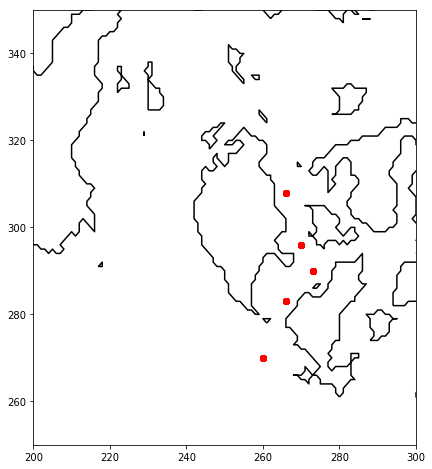

In [24]:
fig, ax = plt.subplots(figsize = ((10,8)))
viz_tools.plot_coastline(ax, grid)
viz_tools.set_aspect(ax)
ax.set_ylim(250,350)
ax.set_xlim(200,300)
ax.plot(list_of_Xinds3, list_of_Yinds3, 'ro');

In [25]:
from matplotlib.colors import LogNorm

In [26]:
s.shape

(14579,)

bias =  0.13149355195223933
RMSE = 0.4185861432367631
Willmott = 0.8417299396308792


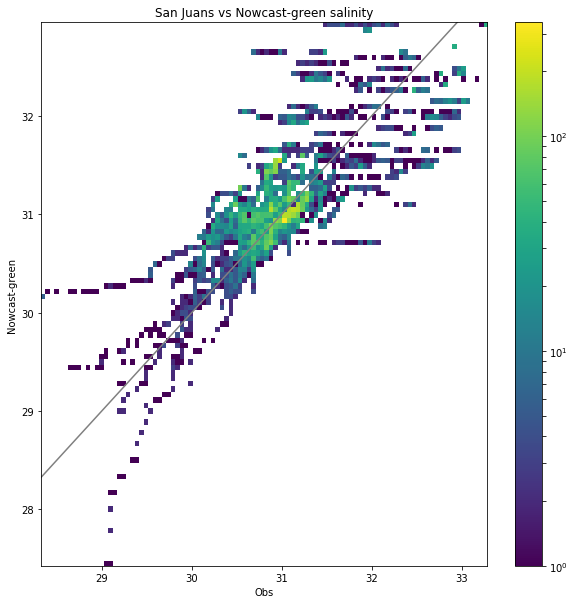

In [28]:
fig, ax = plt.subplots(figsize = (10,10))
c, xedge, yedge, im = ax.hist2d(s, list_of_model_sal, bins = 100, norm=LogNorm())
im
ax.plot(np.arange(28,35), np.arange(28,35), color = 'grey')
fig.colorbar(im, ax=ax)
ax.set_xlabel('Obs')
ax.set_ylabel('Nowcast-green')
ax.set_title('San Juans vs Nowcast-green salinity')

print('bias =  ' + str(-np.mean(s) + np.mean(list_of_model_sal)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_sal - s)**2) 
                              / len(list_of_model_sal))))
xbar = np.mean(s)
print('Willmott = ' + str(1-(np.sum((list_of_model_sal - s)**2)  / 
                             np.sum((np.abs(list_of_model_sal - xbar) 
                                     + np.abs(s - xbar))**2))))

bias =  -0.41816238670848804
RMSE = 0.5876018617134788
Willmott = 0.7423278791118533


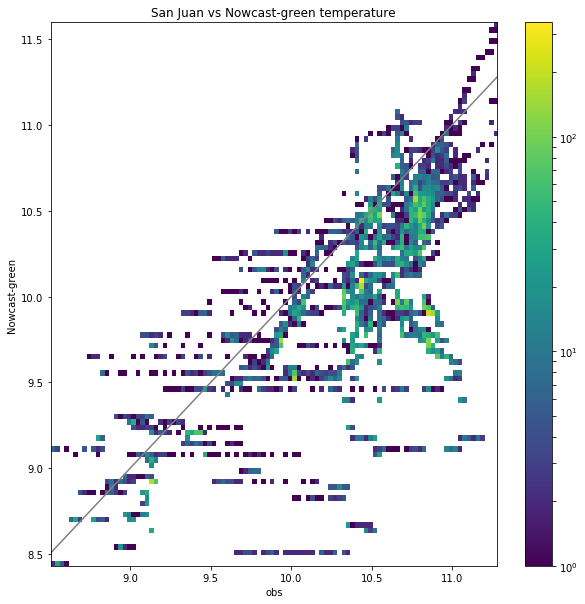

In [29]:
fig, ax = plt.subplots(figsize = (10,10))
c, xedge, yedge, im = ax.hist2d(t, list_of_model_tem, bins = 100, norm=LogNorm())
im
ax.plot(np.arange(35), np.arange(35), color = 'grey')
fig.colorbar(im, ax=ax)
ax.set_xlabel('obs')
ax.set_ylabel('Nowcast-green')
ax.set_title('San Juan vs Nowcast-green temperature')

print('bias =  ' + str(-np.mean(t) + np.mean(list_of_model_tem)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_tem - t)**2) 
                              / len(list_of_model_tem))))
xbar = np.mean(t)
print('Willmott = ' + str(1-(np.sum((list_of_model_tem - t)**2)  / 
                             np.sum((np.abs(list_of_model_tem - xbar) 
                                     + np.abs(t - xbar))**2))))

In [30]:
np.unique(list_of_depths3)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27.])

In [32]:
model_depths3 = np.array([deptht[int(n)] for n in list_of_depths3])

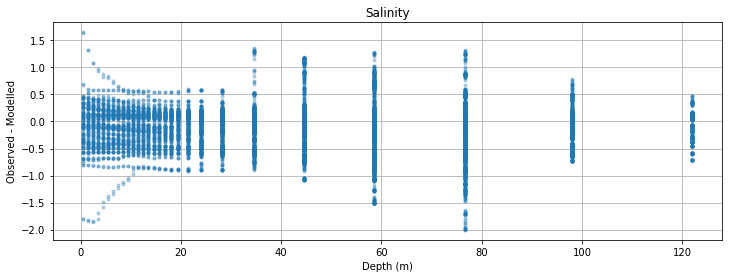

In [33]:
fig, ax = plt.subplots(figsize = (12,4))
ax.plot(model_depths3, s - list_of_model_sal,'.', alpha = 0.3)
ax.grid('on')
ax.set_xlabel('Depth (m)')
ax.set_ylabel('Observed - Modelled')
ax.set_title('Salinity');

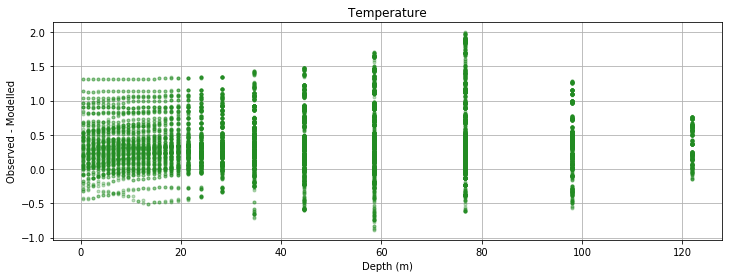

In [34]:
fig, ax = plt.subplots(figsize = (12,4))
ax.plot(model_depths3, t - list_of_model_tem,'.', color = 'ForestGreen', alpha = 0.3)
ax.grid('on')
ax.set_xlabel('Depth (m)')
ax.set_ylabel('Observed - Modelled')
ax.set_title('Temperature');

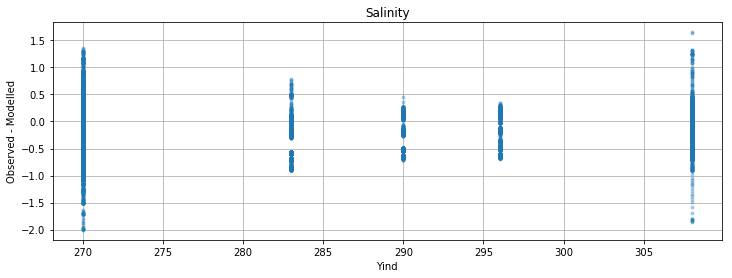

In [35]:
fig, ax = plt.subplots(figsize = (12,4))
ax.plot(list_of_Yinds3, s - list_of_model_sal,'.', alpha = 0.3)
ax.grid('on')
ax.set_xlabel('Yind')
ax.set_ylabel('Observed - Modelled')
ax.set_title('Salinity');

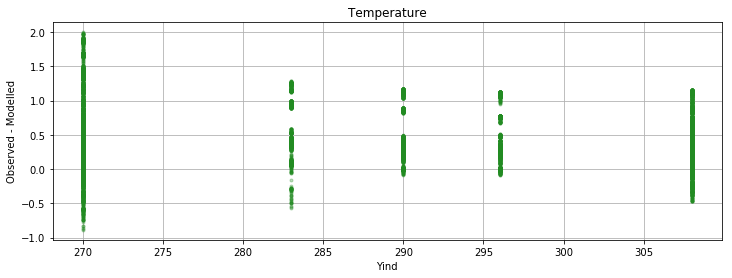

In [36]:
fig, ax = plt.subplots(figsize = (12,4))
ax.plot(list_of_Yinds3, t - list_of_model_tem,'.', color = 'ForestGreen', alpha = 0.3)
ax.grid('on')
ax.set_xlabel('Yind')
ax.set_ylabel('Observed - Modelled')
ax.set_title('Temperature');

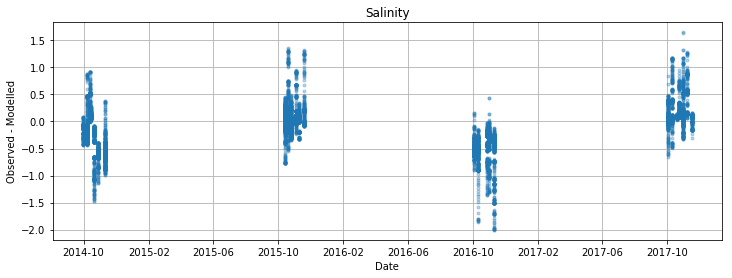

In [37]:
fig, ax = plt.subplots(figsize = (12,4))
ax.plot(list_of_datetimes3, s - list_of_model_sal,'.', alpha = 0.3)
ax.grid('on')
ax.set_xlabel('Date')
ax.set_ylabel('Observed - Modelled')
ax.set_title('Salinity');

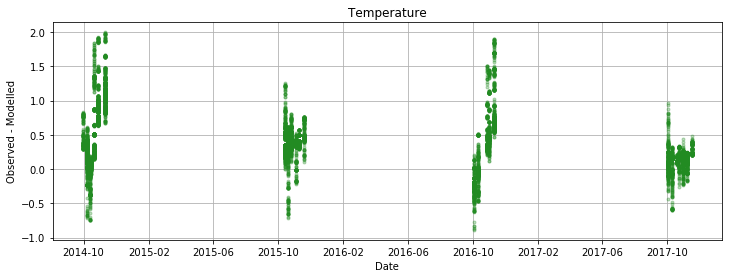

In [38]:
fig, ax = plt.subplots(figsize = (12,4))
ax.plot(list_of_datetimes3, t - list_of_model_tem,'.', color = 'ForestGreen', alpha = 0.3)
ax.grid('on')
ax.set_xlabel('Date')
ax.set_ylabel('Observed - Modelled')
ax.set_title('Temperature');